In [1]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
root_dir = 'C:/Users/frank/data_analysis/age-classification'
path = root_dir + '/archive/train/' #이미지 경로
image_folders = os.listdir(path)
image_folders.pop(0)
image_paths = [path+image_folder for image_folder in image_folders]
modified_path = root_dir + '/archive_sample100/train/' #샘플링된 이미지가 저장될 경로
modified_image_paths = [modified_path+image_folder for image_folder in image_folders]

In [3]:
# modified_path : archive_sample100. 100개 데이터만 샘플링한 것
# 데이터를 바꾸고 싶으면 data_dir에 들어가는 path를 다른 것으로 바꿔주면 됨
data_dir = modified_path
img_height, img_width = 224, 224
batch_size = 32

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4983 files belonging to 53 classes.
Using 3987 files for training.
Found 4983 files belonging to 53 classes.
Using 996 files for validation.


In [5]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


## Base Model

In [6]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

IMG_SHAPE = (img_height, img_width) + (3,)
base_model = tf.keras.applications.resnet.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

In [7]:
for image_batch, label_batch in train_ds:
    feature_batch = base_model(image_batch)
    print(feature_batch.shape)
    break

(32, 7, 7, 2048)


In [8]:
# 처음엔 base model은 train 안되게끔 하고, 임의로 맨 위층에 추가하는 layer만 train
# fine tuning하기 전 last layer를 한 번 train해줘야 한다고 함
base_model.trainable = False

In [9]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

conv2_block3_out (Activation)   (None, 56, 56, 256)  0           conv2_block3_add[0][0]           
__________________________________________________________________________________________________
conv3_block1_1_conv (Conv2D)    (None, 28, 28, 128)  32896       conv2_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block1_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_1_relu (Activation (None, 28, 28, 128)  0           conv3_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block1_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_bloc

__________________________________________________________________________________________________
conv3_block4_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_add (Add)          (None, 28, 28, 512)  0           conv3_block3_out[0][0]           
                                                                 conv3_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 28, 28, 512)  0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 14, 14, 256)  131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block4_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_2_relu (Activation (None, 14, 14, 256)  0           conv4_block4_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block4_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block4_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_add (Add)          (None, 14, 14, 1024) 0           conv4_block3_out[0][0]           
          

__________________________________________________________________________________________________
conv5_block2_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_1_relu (Activation (None, 7, 7, 512)    0           conv5_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_relu (Activation (None, 7, 7, 512)    0           conv5_block2_2_bn[0][0]          
__________

In [10]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [11]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss='mse',
              metrics=['mae'])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [13]:
# callback함수를 이용해서 epoch 5번마다 checkpoint 생성
# 파일 이름에 에포크 번호를 포함시킵니다(`str.format` 포맷)
checkpoint_path = "CP_ResNet50_Sample100_Fine50_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 다섯 번째 에포크마다 가중치를 저장하기 위한 콜백을 만듭니다
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

In [14]:
model.save_weights(checkpoint_path.format(epoch=0))

In [15]:
history = model.fit(train_ds,
                     epochs=30,
                     callbacks=[cp_callback],
                     validation_data=val_ds)

Epoch 1/30
125/125 [==============================] - ETA: 9:39 - loss: 830.7318 - mae: 25.49 - ETA: 4:07 - loss: 654.6231 - mae: 21.09 - ETA: 4:02 - loss: 607.9945 - mae: 20.35 - ETA: 3:57 - loss: 519.2740 - mae: 18.33 - ETA: 3:56 - loss: 484.7116 - mae: 17.80 - ETA: 3:55 - loss: 452.5436 - mae: 17.20 - ETA: 3:54 - loss: 431.1514 - mae: 16.74 - ETA: 3:54 - loss: 404.3497 - mae: 16.23 - ETA: 3:54 - loss: 384.9977 - mae: 15.86 - ETA: 3:54 - loss: 370.4767 - mae: 15.57 - ETA: 3:55 - loss: 360.0259 - mae: 15.38 - ETA: 3:56 - loss: 342.3027 - mae: 14.94 - ETA: 3:56 - loss: 335.6512 - mae: 14.84 - ETA: 3:56 - loss: 326.6812 - mae: 14.70 - ETA: 3:55 - loss: 317.8501 - mae: 14.52 - ETA: 3:54 - loss: 309.8047 - mae: 14.37 - ETA: 3:53 - loss: 304.9738 - mae: 14.30 - ETA: 3:52 - loss: 301.9004 - mae: 14.26 - ETA: 3:52 - loss: 296.3839 - mae: 14.16 - ETA: 3:51 - loss: 293.6794 - mae: 14.13 - ETA: 3:51 - loss: 284.7080 - mae: 13.87 - ETA: 3:51 - loss: 280.0763 - mae: 13.79 - ETA: 3:51 - loss: 278.

125/125 [==============================] - ETA: 5:47 - loss: 189.3568 - mae: 12.07 - ETA: 5:42 - loss: 173.5950 - mae: 11.04 - ETA: 5:38 - loss: 177.0851 - mae: 11.11 - ETA: 5:38 - loss: 176.4657 - mae: 11.19 - ETA: 5:38 - loss: 169.2626 - mae: 11.03 - ETA: 5:41 - loss: 153.8668 - mae: 10.42 - ETA: 5:45 - loss: 150.7598 - mae: 10.34 - ETA: 5:45 - loss: 146.6680 - mae: 10.18 - ETA: 5:42 - loss: 148.4897 - mae: 10.27 - ETA: 5:37 - loss: 146.0653 - mae: 10.17 - ETA: 5:32 - loss: 148.7359 - mae: 10.25 - ETA: 5:27 - loss: 150.4973 - mae: 10.34 - ETA: 5:22 - loss: 150.9022 - mae: 10.35 - ETA: 5:17 - loss: 153.6767 - mae: 10.43 - ETA: 5:12 - loss: 153.7563 - mae: 10.46 - ETA: 5:06 - loss: 154.3445 - mae: 10.48 - ETA: 5:02 - loss: 153.7475 - mae: 10.47 - ETA: 4:58 - loss: 155.4730 - mae: 10.53 - ETA: 4:54 - loss: 155.0170 - mae: 10.52 - ETA: 4:51 - loss: 156.2176 - mae: 10.55 - ETA: 4:47 - loss: 156.1163 - mae: 10.51 - ETA: 4:43 - loss: 156.1061 - mae: 10.50 - ETA: 4:40 - loss: 155.9386 - mae:

125/125 [==============================] - ETA: 8:15 - loss: 113.2168 - mae: 8.417 - ETA: 7:43 - loss: 130.3709 - mae: 9.312 - ETA: 7:29 - loss: 123.5195 - mae: 9.042 - ETA: 7:12 - loss: 130.8732 - mae: 9.360 - ETA: 6:55 - loss: 130.6030 - mae: 9.378 - ETA: 6:38 - loss: 130.7801 - mae: 9.419 - ETA: 6:23 - loss: 131.8050 - mae: 9.520 - ETA: 6:11 - loss: 136.2796 - mae: 9.775 - ETA: 5:59 - loss: 135.1196 - mae: 9.648 - ETA: 5:52 - loss: 142.4010 - mae: 9.880 - ETA: 5:48 - loss: 142.6907 - mae: 9.871 - ETA: 5:41 - loss: 141.0549 - mae: 9.859 - ETA: 5:33 - loss: 142.9050 - mae: 9.970 - ETA: 5:25 - loss: 140.5827 - mae: 9.844 - ETA: 5:18 - loss: 139.2916 - mae: 9.746 - ETA: 5:12 - loss: 137.2722 - mae: 9.649 - ETA: 5:06 - loss: 142.4264 - mae: 9.863 - ETA: 5:00 - loss: 146.9657 - mae: 10.04 - ETA: 4:55 - loss: 144.9501 - mae: 9.9718 - ETA: 4:50 - loss: 145.8792 - mae: 10.00 - ETA: 4:45 - loss: 146.3342 - mae: 10.02 - ETA: 4:41 - loss: 145.8906 - mae: 10.01 - ETA: 4:37 - loss: 145.3258 - mae

125/125 [==============================] - ETA: 5:20 - loss: 158.8909 - mae: 10.74 - ETA: 5:09 - loss: 149.2694 - mae: 10.28 - ETA: 4:59 - loss: 141.0398 - mae: 9.6234 - ETA: 4:55 - loss: 150.7991 - mae: 10.09 - ETA: 4:52 - loss: 149.5136 - mae: 10.11 - ETA: 4:49 - loss: 139.5572 - mae: 9.7302 - ETA: 4:46 - loss: 138.7538 - mae: 9.661 - ETA: 4:43 - loss: 137.1667 - mae: 9.588 - ETA: 4:41 - loss: 138.8055 - mae: 9.600 - ETA: 4:38 - loss: 144.0214 - mae: 9.808 - ETA: 4:36 - loss: 144.8284 - mae: 9.783 - ETA: 4:35 - loss: 145.3840 - mae: 9.823 - ETA: 4:34 - loss: 141.1665 - mae: 9.683 - ETA: 4:32 - loss: 143.7021 - mae: 9.806 - ETA: 4:30 - loss: 141.3511 - mae: 9.725 - ETA: 4:28 - loss: 140.7953 - mae: 9.720 - ETA: 4:27 - loss: 141.8834 - mae: 9.767 - ETA: 4:25 - loss: 143.2958 - mae: 9.782 - ETA: 4:23 - loss: 143.3404 - mae: 9.793 - ETA: 4:22 - loss: 143.3788 - mae: 9.817 - ETA: 4:21 - loss: 143.7298 - mae: 9.802 - ETA: 4:19 - loss: 144.1398 - mae: 9.843 - ETA: 4:17 - loss: 144.9806 - ma

125/125 [==============================] - ETA: 7:38 - loss: 132.9597 - mae: 9.739 - ETA: 8:34 - loss: 131.9988 - mae: 9.705 - ETA: 9:04 - loss: 151.1831 - mae: 10.32 - ETA: 9:18 - loss: 136.1936 - mae: 9.7416 - ETA: 9:27 - loss: 136.6366 - mae: 9.725 - ETA: 9:14 - loss: 135.4984 - mae: 9.588 - ETA: 9:04 - loss: 129.4950 - mae: 9.452 - ETA: 8:48 - loss: 127.6797 - mae: 9.366 - ETA: 8:29 - loss: 132.0016 - mae: 9.489 - ETA: 8:11 - loss: 135.1398 - mae: 9.643 - ETA: 7:51 - loss: 136.1877 - mae: 9.671 - ETA: 7:33 - loss: 135.4884 - mae: 9.623 - ETA: 7:16 - loss: 139.1465 - mae: 9.740 - ETA: 7:01 - loss: 137.7953 - mae: 9.683 - ETA: 6:47 - loss: 142.5928 - mae: 9.810 - ETA: 6:34 - loss: 144.4141 - mae: 9.907 - ETA: 6:22 - loss: 145.2293 - mae: 9.972 - ETA: 6:12 - loss: 143.1461 - mae: 9.909 - ETA: 6:02 - loss: 143.8055 - mae: 9.949 - ETA: 5:53 - loss: 141.9204 - mae: 9.875 - ETA: 5:45 - loss: 144.5618 - mae: 9.951 - ETA: 5:37 - loss: 145.6739 - mae: 10.00 - ETA: 5:30 - loss: 143.4276 - mae

125/125 [==============================] - ETA: 5:27 - loss: 159.2164 - mae: 9.136 - ETA: 5:18 - loss: 127.8120 - mae: 8.653 - ETA: 5:14 - loss: 134.6448 - mae: 9.514 - ETA: 5:07 - loss: 133.6369 - mae: 9.399 - ETA: 5:02 - loss: 138.2536 - mae: 9.631 - ETA: 4:59 - loss: 134.7060 - mae: 9.513 - ETA: 4:56 - loss: 134.6336 - mae: 9.520 - ETA: 4:55 - loss: 139.7536 - mae: 9.698 - ETA: 4:53 - loss: 141.6418 - mae: 9.770 - ETA: 4:52 - loss: 139.4077 - mae: 9.740 - ETA: 4:51 - loss: 140.1067 - mae: 9.678 - ETA: 4:51 - loss: 137.4633 - mae: 9.577 - ETA: 4:51 - loss: 137.7534 - mae: 9.606 - ETA: 4:52 - loss: 136.8855 - mae: 9.572 - ETA: 4:53 - loss: 134.7850 - mae: 9.507 - ETA: 4:53 - loss: 132.6440 - mae: 9.407 - ETA: 4:51 - loss: 132.7110 - mae: 9.428 - ETA: 4:48 - loss: 133.2628 - mae: 9.464 - ETA: 4:45 - loss: 131.2180 - mae: 9.383 - ETA: 4:42 - loss: 132.6280 - mae: 9.401 - ETA: 4:38 - loss: 132.1009 - mae: 9.423 - ETA: 4:35 - loss: 131.6982 - mae: 9.428 - ETA: 4:31 - loss: 132.6818 - mae:

125/125 [==============================] - ETA: 5:47 - loss: 102.2205 - mae: 8.058 - ETA: 7:16 - loss: 105.5710 - mae: 8.294 - ETA: 7:15 - loss: 137.9097 - mae: 9.637 - ETA: 7:07 - loss: 130.3915 - mae: 9.281 - ETA: 6:59 - loss: 138.8050 - mae: 9.708 - ETA: 6:46 - loss: 137.5466 - mae: 9.709 - ETA: 6:34 - loss: 136.8740 - mae: 9.681 - ETA: 6:21 - loss: 134.9478 - mae: 9.578 - ETA: 6:10 - loss: 134.4042 - mae: 9.556 - ETA: 5:59 - loss: 132.2486 - mae: 9.499 - ETA: 5:50 - loss: 128.5547 - mae: 9.292 - ETA: 5:41 - loss: 125.3703 - mae: 9.163 - ETA: 5:34 - loss: 127.0270 - mae: 9.230 - ETA: 5:26 - loss: 125.5015 - mae: 9.172 - ETA: 5:20 - loss: 126.2042 - mae: 9.141 - ETA: 5:13 - loss: 124.9025 - mae: 9.109 - ETA: 5:08 - loss: 128.6092 - mae: 9.245 - ETA: 5:02 - loss: 131.3058 - mae: 9.381 - ETA: 4:57 - loss: 130.7032 - mae: 9.359 - ETA: 4:52 - loss: 134.1844 - mae: 9.476 - ETA: 4:49 - loss: 135.1627 - mae: 9.489 - ETA: 4:46 - loss: 134.7614 - mae: 9.499 - ETA: 4:43 - loss: 134.2801 - mae:

125/125 [==============================] - ETA: 5:33 - loss: 139.4477 - mae: 8.984 - ETA: 5:21 - loss: 127.1711 - mae: 8.581 - ETA: 5:20 - loss: 120.2501 - mae: 8.405 - ETA: 5:17 - loss: 118.1212 - mae: 8.408 - ETA: 5:17 - loss: 113.3566 - mae: 8.226 - ETA: 5:19 - loss: 119.2010 - mae: 8.508 - ETA: 5:21 - loss: 118.3935 - mae: 8.535 - ETA: 5:25 - loss: 114.5220 - mae: 8.395 - ETA: 5:31 - loss: 118.0652 - mae: 8.594 - ETA: 5:36 - loss: 120.2985 - mae: 8.638 - ETA: 5:38 - loss: 122.8349 - mae: 8.826 - ETA: 5:36 - loss: 126.6542 - mae: 8.954 - ETA: 5:32 - loss: 128.0081 - mae: 8.977 - ETA: 5:28 - loss: 129.6442 - mae: 9.040 - ETA: 5:23 - loss: 131.2348 - mae: 9.169 - ETA: 5:18 - loss: 134.2035 - mae: 9.329 - ETA: 5:13 - loss: 132.6346 - mae: 9.267 - ETA: 5:08 - loss: 131.2310 - mae: 9.231 - ETA: 5:03 - loss: 130.4582 - mae: 9.220 - ETA: 4:58 - loss: 131.6761 - mae: 9.260 - ETA: 4:53 - loss: 134.0348 - mae: 9.358 - ETA: 4:48 - loss: 134.4970 - mae: 9.372 - ETA: 4:44 - loss: 132.8214 - mae:

125/125 [==============================] - ETA: 5:06 - loss: 137.7908 - mae: 9.104 - ETA: 5:23 - loss: 135.3873 - mae: 9.380 - ETA: 5:08 - loss: 132.6662 - mae: 9.397 - ETA: 5:02 - loss: 126.3678 - mae: 9.258 - ETA: 4:58 - loss: 129.8502 - mae: 9.398 - ETA: 4:59 - loss: 123.4469 - mae: 9.018 - ETA: 5:01 - loss: 126.0163 - mae: 9.171 - ETA: 5:06 - loss: 125.7496 - mae: 9.098 - ETA: 5:09 - loss: 129.6337 - mae: 9.284 - ETA: 5:12 - loss: 129.5582 - mae: 9.333 - ETA: 5:14 - loss: 126.5768 - mae: 9.220 - ETA: 5:14 - loss: 129.0537 - mae: 9.320 - ETA: 5:11 - loss: 130.0170 - mae: 9.357 - ETA: 5:08 - loss: 126.9676 - mae: 9.237 - ETA: 5:04 - loss: 125.2475 - mae: 9.153 - ETA: 5:01 - loss: 126.3038 - mae: 9.174 - ETA: 4:56 - loss: 126.4814 - mae: 9.146 - ETA: 4:52 - loss: 126.3158 - mae: 9.122 - ETA: 4:48 - loss: 128.6519 - mae: 9.208 - ETA: 4:44 - loss: 129.2559 - mae: 9.226 - ETA: 4:40 - loss: 130.9893 - mae: 9.307 - ETA: 4:36 - loss: 133.3799 - mae: 9.380 - ETA: 4:32 - loss: 130.7383 - mae:

125/125 [==============================] - ETA: 5:22 - loss: 148.8506 - mae: 10.05 - ETA: 5:43 - loss: 146.4010 - mae: 9.8881 - ETA: 5:44 - loss: 130.9709 - mae: 9.270 - ETA: 5:44 - loss: 129.5628 - mae: 9.183 - ETA: 5:31 - loss: 129.9760 - mae: 9.225 - ETA: 5:21 - loss: 128.9246 - mae: 9.175 - ETA: 5:14 - loss: 129.5604 - mae: 9.201 - ETA: 5:09 - loss: 128.2070 - mae: 9.139 - ETA: 5:05 - loss: 124.9881 - mae: 9.037 - ETA: 5:02 - loss: 133.5370 - mae: 9.329 - ETA: 5:00 - loss: 132.1001 - mae: 9.253 - ETA: 4:58 - loss: 134.0390 - mae: 9.331 - ETA: 4:57 - loss: 132.0762 - mae: 9.254 - ETA: 4:56 - loss: 129.4898 - mae: 9.132 - ETA: 4:56 - loss: 128.9772 - mae: 9.143 - ETA: 4:57 - loss: 127.7291 - mae: 9.128 - ETA: 5:00 - loss: 129.4977 - mae: 9.222 - ETA: 5:01 - loss: 130.2896 - mae: 9.255 - ETA: 5:00 - loss: 127.1313 - mae: 9.101 - ETA: 4:58 - loss: 127.6937 - mae: 9.115 - ETA: 4:56 - loss: 125.5818 - mae: 9.035 - ETA: 4:56 - loss: 124.4522 - mae: 9.001 - ETA: 4:54 - loss: 124.8832 - mae

125/125 [==============================] - ETA: 5:41 - loss: 107.8675 - mae: 8.474 - ETA: 5:35 - loss: 110.8091 - mae: 8.551 - ETA: 5:27 - loss: 110.4239 - mae: 8.474 - ETA: 5:20 - loss: 111.1714 - mae: 8.625 - ETA: 5:14 - loss: 108.7323 - mae: 8.483 - ETA: 5:07 - loss: 121.5236 - mae: 9.048 - ETA: 5:02 - loss: 118.4836 - mae: 8.940 - ETA: 4:58 - loss: 117.3669 - mae: 8.968 - ETA: 4:53 - loss: 119.8903 - mae: 9.059 - ETA: 4:49 - loss: 121.7755 - mae: 9.127 - ETA: 4:46 - loss: 120.1222 - mae: 9.018 - ETA: 4:43 - loss: 119.7096 - mae: 8.981 - ETA: 4:39 - loss: 117.8680 - mae: 8.893 - ETA: 4:37 - loss: 122.1588 - mae: 9.042 - ETA: 4:34 - loss: 121.9775 - mae: 9.030 - ETA: 4:31 - loss: 121.6795 - mae: 9.034 - ETA: 4:28 - loss: 124.2542 - mae: 9.087 - ETA: 4:26 - loss: 123.6176 - mae: 9.036 - ETA: 4:24 - loss: 124.1701 - mae: 9.034 - ETA: 4:21 - loss: 123.8977 - mae: 9.041 - ETA: 4:20 - loss: 123.0399 - mae: 9.014 - ETA: 4:18 - loss: 124.8973 - mae: 9.113 - ETA: 4:16 - loss: 126.8764 - mae:

125/125 [==============================] - ETA: 6:03 - loss: 177.6689 - mae: 10.77 - ETA: 6:40 - loss: 155.2271 - mae: 9.9997 - ETA: 6:38 - loss: 143.4388 - mae: 9.578 - ETA: 6:38 - loss: 135.5529 - mae: 9.469 - ETA: 6:40 - loss: 126.9933 - mae: 9.211 - ETA: 6:45 - loss: 126.8526 - mae: 9.207 - ETA: 6:56 - loss: 121.5036 - mae: 8.940 - ETA: 7:06 - loss: 123.1627 - mae: 9.034 - ETA: 7:35 - loss: 120.6318 - mae: 8.811 - ETA: 8:13 - loss: 120.1643 - mae: 8.818 - ETA: 8:18 - loss: 120.4274 - mae: 8.826 - ETA: 8:14 - loss: 122.6117 - mae: 8.845 - ETA: 8:04 - loss: 123.0104 - mae: 8.922 - ETA: 7:52 - loss: 123.3467 - mae: 8.919 - ETA: 7:44 - loss: 126.5872 - mae: 9.063 - ETA: 7:30 - loss: 127.7919 - mae: 9.141 - ETA: 7:20 - loss: 127.5631 - mae: 9.152 - ETA: 7:08 - loss: 125.9830 - mae: 9.097 - ETA: 6:56 - loss: 126.0806 - mae: 9.113 - ETA: 6:45 - loss: 128.2860 - mae: 9.185 - ETA: 6:35 - loss: 129.0047 - mae: 9.182 - ETA: 6:26 - loss: 130.7601 - mae: 9.278 - ETA: 6:17 - loss: 131.1868 - mae

125/125 [==============================] - ETA: 7:52 - loss: 161.1959 - mae: 10.00 - ETA: 6:57 - loss: 150.4281 - mae: 9.8669 - ETA: 6:40 - loss: 135.4202 - mae: 9.084 - ETA: 6:23 - loss: 128.0938 - mae: 8.885 - ETA: 6:10 - loss: 126.2686 - mae: 8.935 - ETA: 5:58 - loss: 120.6532 - mae: 8.702 - ETA: 5:49 - loss: 123.5390 - mae: 8.928 - ETA: 5:42 - loss: 117.5814 - mae: 8.685 - ETA: 5:35 - loss: 118.6514 - mae: 8.685 - ETA: 5:28 - loss: 121.4699 - mae: 8.796 - ETA: 5:22 - loss: 121.2511 - mae: 8.819 - ETA: 5:17 - loss: 124.1466 - mae: 8.939 - ETA: 5:13 - loss: 123.8872 - mae: 8.935 - ETA: 5:08 - loss: 121.3691 - mae: 8.883 - ETA: 5:03 - loss: 120.7708 - mae: 8.849 - ETA: 4:59 - loss: 119.3669 - mae: 8.782 - ETA: 4:55 - loss: 123.6973 - mae: 8.954 - ETA: 4:52 - loss: 126.4650 - mae: 9.057 - ETA: 4:49 - loss: 125.5239 - mae: 9.008 - ETA: 4:46 - loss: 125.5179 - mae: 9.007 - ETA: 4:43 - loss: 127.1450 - mae: 9.060 - ETA: 4:41 - loss: 127.6331 - mae: 9.086 - ETA: 4:39 - loss: 128.3036 - mae

125/125 [==============================] - ETA: 7:58 - loss: 117.0731 - mae: 8.779 - ETA: 7:40 - loss: 116.5010 - mae: 8.846 - ETA: 7:09 - loss: 120.9179 - mae: 8.874 - ETA: 6:50 - loss: 122.1203 - mae: 8.894 - ETA: 6:29 - loss: 118.3354 - mae: 8.807 - ETA: 6:30 - loss: 116.8939 - mae: 8.747 - ETA: 6:22 - loss: 123.6965 - mae: 9.012 - ETA: 6:12 - loss: 120.1467 - mae: 8.811 - ETA: 6:00 - loss: 115.8727 - mae: 8.631 - ETA: 5:48 - loss: 119.0838 - mae: 8.805 - ETA: 5:38 - loss: 117.1114 - mae: 8.700 - ETA: 5:30 - loss: 119.1986 - mae: 8.755 - ETA: 5:22 - loss: 119.5443 - mae: 8.789 - ETA: 5:16 - loss: 119.6504 - mae: 8.815 - ETA: 5:10 - loss: 120.3424 - mae: 8.843 - ETA: 5:05 - loss: 121.7761 - mae: 8.894 - ETA: 4:59 - loss: 121.0320 - mae: 8.890 - ETA: 4:55 - loss: 123.3446 - mae: 9.002 - ETA: 4:50 - loss: 122.7493 - mae: 8.970 - ETA: 4:46 - loss: 121.9507 - mae: 8.955 - ETA: 4:42 - loss: 121.9479 - mae: 8.949 - ETA: 4:38 - loss: 123.6810 - mae: 8.976 - ETA: 4:35 - loss: 123.1312 - mae:

125/125 [==============================] - ETA: 5:22 - loss: 107.2320 - mae: 7.725 - ETA: 5:20 - loss: 102.9410 - mae: 7.749 - ETA: 5:06 - loss: 110.8954 - mae: 8.054 - ETA: 5:02 - loss: 105.8970 - mae: 8.057 - ETA: 5:00 - loss: 112.0563 - mae: 8.278 - ETA: 4:58 - loss: 109.1848 - mae: 8.272 - ETA: 4:57 - loss: 120.6452 - mae: 8.707 - ETA: 4:56 - loss: 121.7814 - mae: 8.753 - ETA: 4:55 - loss: 122.7142 - mae: 8.705 - ETA: 4:54 - loss: 119.6313 - mae: 8.644 - ETA: 4:54 - loss: 122.2003 - mae: 8.798 - ETA: 4:54 - loss: 123.6592 - mae: 8.877 - ETA: 4:57 - loss: 121.0955 - mae: 8.790 - ETA: 4:59 - loss: 123.4978 - mae: 8.901 - ETA: 5:04 - loss: 124.1431 - mae: 8.895 - ETA: 5:08 - loss: 124.3982 - mae: 8.935 - ETA: 5:11 - loss: 126.1637 - mae: 9.009 - ETA: 5:11 - loss: 122.0965 - mae: 8.842 - ETA: 5:09 - loss: 122.0832 - mae: 8.832 - ETA: 5:06 - loss: 123.1909 - mae: 8.900 - ETA: 5:03 - loss: 125.7191 - mae: 8.963 - ETA: 4:59 - loss: 126.1683 - mae: 9.021 - ETA: 4:55 - loss: 125.1125 - mae:

125/125 [==============================] - ETA: 5:20 - loss: 135.7001 - mae: 8.841 - ETA: 5:16 - loss: 148.2737 - mae: 9.832 - ETA: 5:16 - loss: 138.9186 - mae: 9.647 - ETA: 5:16 - loss: 128.9269 - mae: 9.356 - ETA: 5:18 - loss: 116.2316 - mae: 8.666 - ETA: 5:18 - loss: 116.6073 - mae: 8.737 - ETA: 5:19 - loss: 110.7918 - mae: 8.555 - ETA: 5:26 - loss: 112.6703 - mae: 8.670 - ETA: 5:34 - loss: 117.5420 - mae: 8.837 - ETA: 5:40 - loss: 116.7550 - mae: 8.838 - ETA: 5:43 - loss: 117.1851 - mae: 8.793 - ETA: 5:49 - loss: 114.8296 - mae: 8.687 - ETA: 5:56 - loss: 120.6784 - mae: 8.874 - ETA: 5:55 - loss: 123.2836 - mae: 9.003 - ETA: 5:52 - loss: 124.1326 - mae: 9.062 - ETA: 5:48 - loss: 123.2900 - mae: 9.037 - ETA: 5:43 - loss: 121.8742 - mae: 8.905 - ETA: 5:37 - loss: 123.1522 - mae: 8.947 - ETA: 5:31 - loss: 123.3282 - mae: 8.975 - ETA: 5:25 - loss: 123.1348 - mae: 8.959 - ETA: 5:19 - loss: 122.4094 - mae: 8.928 - ETA: 5:14 - loss: 124.0551 - mae: 9.018 - ETA: 5:08 - loss: 123.3761 - mae:

125/125 [==============================] - ETA: 5:25 - loss: 189.5283 - mae: 11.67 - ETA: 5:07 - loss: 161.5572 - mae: 10.59 - ETA: 5:01 - loss: 133.6814 - mae: 9.4864 - ETA: 4:57 - loss: 133.1228 - mae: 9.467 - ETA: 4:54 - loss: 134.5374 - mae: 9.533 - ETA: 4:51 - loss: 125.9692 - mae: 9.282 - ETA: 4:48 - loss: 132.9942 - mae: 9.571 - ETA: 4:45 - loss: 134.5859 - mae: 9.705 - ETA: 4:43 - loss: 127.9639 - mae: 9.353 - ETA: 4:44 - loss: 123.6673 - mae: 9.168 - ETA: 4:42 - loss: 127.6975 - mae: 9.343 - ETA: 4:39 - loss: 130.1373 - mae: 9.411 - ETA: 4:37 - loss: 129.1091 - mae: 9.363 - ETA: 4:36 - loss: 132.0032 - mae: 9.494 - ETA: 4:35 - loss: 126.8744 - mae: 9.281 - ETA: 4:33 - loss: 125.9534 - mae: 9.246 - ETA: 4:32 - loss: 125.0100 - mae: 9.198 - ETA: 4:31 - loss: 122.6483 - mae: 9.074 - ETA: 4:31 - loss: 120.6498 - mae: 8.966 - ETA: 4:31 - loss: 120.4948 - mae: 8.945 - ETA: 4:32 - loss: 123.2068 - mae: 9.017 - ETA: 4:34 - loss: 121.8964 - mae: 8.943 - ETA: 4:37 - loss: 124.0854 - mae

125/125 [==============================] - ETA: 5:30 - loss: 130.9211 - mae: 9.640 - ETA: 5:26 - loss: 123.3595 - mae: 9.211 - ETA: 5:19 - loss: 129.6525 - mae: 9.068 - ETA: 5:17 - loss: 123.8708 - mae: 8.758 - ETA: 5:19 - loss: 123.0470 - mae: 8.658 - ETA: 5:19 - loss: 120.9490 - mae: 8.830 - ETA: 5:20 - loss: 128.6598 - mae: 9.115 - ETA: 5:22 - loss: 126.0828 - mae: 9.091 - ETA: 5:27 - loss: 123.5410 - mae: 9.043 - ETA: 5:32 - loss: 125.0994 - mae: 9.101 - ETA: 5:38 - loss: 122.1595 - mae: 8.972 - ETA: 5:42 - loss: 122.4334 - mae: 8.978 - ETA: 5:42 - loss: 121.5771 - mae: 8.972 - ETA: 5:40 - loss: 125.2209 - mae: 9.109 - ETA: 5:37 - loss: 126.4301 - mae: 9.144 - ETA: 5:32 - loss: 123.1846 - mae: 9.023 - ETA: 5:27 - loss: 122.6465 - mae: 9.006 - ETA: 5:22 - loss: 119.9939 - mae: 8.884 - ETA: 5:16 - loss: 121.0970 - mae: 8.941 - ETA: 5:11 - loss: 123.4821 - mae: 9.015 - ETA: 5:06 - loss: 125.3633 - mae: 9.085 - ETA: 5:00 - loss: 125.0800 - mae: 9.054 - ETA: 4:56 - loss: 124.0283 - mae:

125/125 [==============================] - ETA: 5:07 - loss: 80.4650 - mae: 7.47 - ETA: 5:27 - loss: 100.1640 - mae: 8.223 - ETA: 5:11 - loss: 101.4666 - mae: 8.305 - ETA: 5:05 - loss: 103.9581 - mae: 8.401 - ETA: 4:59 - loss: 114.7231 - mae: 8.773 - ETA: 4:55 - loss: 111.8860 - mae: 8.760 - ETA: 4:52 - loss: 110.2206 - mae: 8.667 - ETA: 4:48 - loss: 111.4311 - mae: 8.711 - ETA: 4:45 - loss: 118.1817 - mae: 8.897 - ETA: 4:42 - loss: 117.1324 - mae: 8.833 - ETA: 4:39 - loss: 118.9277 - mae: 8.920 - ETA: 4:37 - loss: 119.9568 - mae: 8.934 - ETA: 4:35 - loss: 118.0051 - mae: 8.841 - ETA: 4:33 - loss: 120.8815 - mae: 8.927 - ETA: 4:32 - loss: 121.8235 - mae: 8.980 - ETA: 4:30 - loss: 122.7814 - mae: 9.003 - ETA: 4:28 - loss: 124.2529 - mae: 9.066 - ETA: 4:27 - loss: 122.9154 - mae: 8.975 - ETA: 4:26 - loss: 124.9001 - mae: 9.004 - ETA: 4:26 - loss: 124.8319 - mae: 8.988 - ETA: 4:25 - loss: 127.2279 - mae: 9.098 - ETA: 4:26 - loss: 125.8430 - mae: 9.051 - ETA: 4:28 - loss: 125.9202 - mae: 9

125/125 [==============================] - ETA: 8:42 - loss: 129.8353 - mae: 9.310 - ETA: 9:28 - loss: 120.0188 - mae: 8.878 - ETA: 9:01 - loss: 114.5200 - mae: 8.757 - ETA: 8:31 - loss: 115.0009 - mae: 8.732 - ETA: 8:06 - loss: 112.5402 - mae: 8.498 - ETA: 7:44 - loss: 116.7281 - mae: 8.734 - ETA: 7:24 - loss: 114.5209 - mae: 8.592 - ETA: 7:05 - loss: 119.8460 - mae: 8.790 - ETA: 6:50 - loss: 120.1329 - mae: 8.788 - ETA: 6:37 - loss: 119.9104 - mae: 8.748 - ETA: 6:25 - loss: 117.8375 - mae: 8.640 - ETA: 6:14 - loss: 116.9190 - mae: 8.611 - ETA: 6:05 - loss: 119.8520 - mae: 8.688 - ETA: 5:56 - loss: 118.1357 - mae: 8.673 - ETA: 5:47 - loss: 118.3163 - mae: 8.673 - ETA: 5:40 - loss: 116.9066 - mae: 8.629 - ETA: 5:33 - loss: 116.1540 - mae: 8.620 - ETA: 5:27 - loss: 117.9133 - mae: 8.683 - ETA: 5:21 - loss: 119.1811 - mae: 8.728 - ETA: 5:15 - loss: 120.5765 - mae: 8.803 - ETA: 5:11 - loss: 120.2139 - mae: 8.769 - ETA: 5:07 - loss: 120.9694 - mae: 8.793 - ETA: 5:03 - loss: 124.9463 - mae:

125/125 [==============================] - ETA: 6:23 - loss: 137.2866 - mae: 9.771 - ETA: 6:20 - loss: 130.1322 - mae: 9.400 - ETA: 6:08 - loss: 129.0970 - mae: 9.084 - ETA: 5:55 - loss: 127.3444 - mae: 9.196 - ETA: 5:46 - loss: 128.8769 - mae: 9.411 - ETA: 5:40 - loss: 126.4282 - mae: 9.399 - ETA: 5:34 - loss: 126.5307 - mae: 9.368 - ETA: 5:28 - loss: 128.2016 - mae: 9.368 - ETA: 5:22 - loss: 122.9863 - mae: 9.088 - ETA: 5:16 - loss: 121.8891 - mae: 8.979 - ETA: 5:11 - loss: 117.2936 - mae: 8.784 - ETA: 5:07 - loss: 118.8263 - mae: 8.791 - ETA: 5:03 - loss: 117.6852 - mae: 8.745 - ETA: 4:59 - loss: 122.1830 - mae: 8.874 - ETA: 4:55 - loss: 121.4394 - mae: 8.855 - ETA: 4:52 - loss: 120.5736 - mae: 8.888 - ETA: 4:49 - loss: 120.5290 - mae: 8.859 - ETA: 4:47 - loss: 122.4163 - mae: 8.918 - ETA: 4:44 - loss: 121.4228 - mae: 8.916 - ETA: 4:42 - loss: 123.7351 - mae: 9.006 - ETA: 4:40 - loss: 126.6700 - mae: 9.095 - ETA: 4:39 - loss: 126.3435 - mae: 9.077 - ETA: 4:38 - loss: 127.9802 - mae:

125/125 [==============================] - ETA: 5:26 - loss: 108.7779 - mae: 8.430 - ETA: 6:00 - loss: 92.4835 - mae: 7.993 - ETA: 5:44 - loss: 106.8372 - mae: 8.528 - ETA: 5:42 - loss: 105.6877 - mae: 8.460 - ETA: 5:44 - loss: 105.9854 - mae: 8.405 - ETA: 5:47 - loss: 107.0525 - mae: 8.433 - ETA: 5:51 - loss: 103.4909 - mae: 8.287 - ETA: 5:57 - loss: 100.7222 - mae: 8.208 - ETA: 6:04 - loss: 107.3111 - mae: 8.440 - ETA: 6:08 - loss: 109.3871 - mae: 8.591 - ETA: 6:06 - loss: 111.9388 - mae: 8.667 - ETA: 6:02 - loss: 112.3640 - mae: 8.701 - ETA: 5:56 - loss: 110.9057 - mae: 8.629 - ETA: 5:50 - loss: 113.5141 - mae: 8.686 - ETA: 5:43 - loss: 111.3276 - mae: 8.595 - ETA: 5:36 - loss: 113.1798 - mae: 8.628 - ETA: 5:30 - loss: 113.2305 - mae: 8.611 - ETA: 5:23 - loss: 113.2978 - mae: 8.610 - ETA: 5:17 - loss: 113.7964 - mae: 8.615 - ETA: 5:11 - loss: 115.0604 - mae: 8.662 - ETA: 5:06 - loss: 116.4374 - mae: 8.707 - ETA: 5:00 - loss: 116.7925 - mae: 8.701 - ETA: 4:55 - loss: 117.6103 - mae: 

125/125 [==============================] - ETA: 5:08 - loss: 118.5492 - mae: 8.850 - ETA: 5:09 - loss: 123.1972 - mae: 8.932 - ETA: 5:06 - loss: 113.6511 - mae: 8.647 - ETA: 5:15 - loss: 132.9468 - mae: 9.114 - ETA: 5:16 - loss: 136.6913 - mae: 9.314 - ETA: 5:13 - loss: 134.4103 - mae: 9.228 - ETA: 5:10 - loss: 129.4034 - mae: 9.009 - ETA: 5:11 - loss: 123.1847 - mae: 8.804 - ETA: 5:14 - loss: 124.0169 - mae: 8.924 - ETA: 5:18 - loss: 120.5827 - mae: 8.823 - ETA: 5:19 - loss: 122.0724 - mae: 8.894 - ETA: 5:19 - loss: 122.1787 - mae: 8.941 - ETA: 5:20 - loss: 124.5982 - mae: 9.078 - ETA: 5:24 - loss: 127.2079 - mae: 9.163 - ETA: 5:31 - loss: 125.1348 - mae: 9.081 - ETA: 5:40 - loss: 124.3940 - mae: 9.032 - ETA: 5:49 - loss: 124.4270 - mae: 8.975 - ETA: 5:55 - loss: 121.8636 - mae: 8.872 - ETA: 5:54 - loss: 122.4377 - mae: 8.916 - ETA: 5:52 - loss: 122.9448 - mae: 8.961 - ETA: 5:48 - loss: 125.3782 - mae: 9.046 - ETA: 5:44 - loss: 124.7922 - mae: 9.009 - ETA: 5:42 - loss: 123.0939 - mae:

125/125 [==============================] - ETA: 5:21 - loss: 102.1916 - mae: 8.388 - ETA: 5:10 - loss: 110.2392 - mae: 8.558 - ETA: 5:05 - loss: 101.4293 - mae: 8.135 - ETA: 5:02 - loss: 103.2302 - mae: 8.251 - ETA: 5:01 - loss: 109.2137 - mae: 8.535 - ETA: 4:58 - loss: 114.1777 - mae: 8.645 - ETA: 4:54 - loss: 121.9228 - mae: 9.004 - ETA: 4:51 - loss: 123.7063 - mae: 9.041 - ETA: 4:48 - loss: 120.7665 - mae: 8.900 - ETA: 4:45 - loss: 118.8436 - mae: 8.834 - ETA: 4:43 - loss: 113.9743 - mae: 8.625 - ETA: 4:41 - loss: 110.5251 - mae: 8.508 - ETA: 4:39 - loss: 113.3338 - mae: 8.558 - ETA: 4:37 - loss: 113.3949 - mae: 8.571 - ETA: 4:36 - loss: 116.1833 - mae: 8.684 - ETA: 4:36 - loss: 115.6153 - mae: 8.685 - ETA: 4:35 - loss: 114.0151 - mae: 8.598 - ETA: 4:35 - loss: 117.0132 - mae: 8.716 - ETA: 4:37 - loss: 119.7916 - mae: 8.807 - ETA: 4:39 - loss: 121.0102 - mae: 8.812 - ETA: 4:41 - loss: 118.7303 - mae: 8.732 - ETA: 4:44 - loss: 118.5077 - mae: 8.727 - ETA: 4:44 - loss: 118.2887 - mae:

125/125 [==============================] - ETA: 6:54 - loss: 133.2489 - mae: 9.339 - ETA: 7:45 - loss: 129.6759 - mae: 9.336 - ETA: 7:13 - loss: 127.5350 - mae: 9.251 - ETA: 6:45 - loss: 119.0185 - mae: 8.774 - ETA: 6:27 - loss: 118.7562 - mae: 8.784 - ETA: 6:11 - loss: 112.6578 - mae: 8.510 - ETA: 5:59 - loss: 114.7770 - mae: 8.584 - ETA: 5:49 - loss: 110.1782 - mae: 8.405 - ETA: 5:39 - loss: 110.8788 - mae: 8.450 - ETA: 5:31 - loss: 111.1580 - mae: 8.412 - ETA: 5:24 - loss: 112.0934 - mae: 8.434 - ETA: 5:17 - loss: 112.8187 - mae: 8.457 - ETA: 5:12 - loss: 110.8079 - mae: 8.437 - ETA: 5:07 - loss: 110.6478 - mae: 8.455 - ETA: 5:02 - loss: 113.1385 - mae: 8.550 - ETA: 4:57 - loss: 116.6411 - mae: 8.710 - ETA: 4:52 - loss: 115.6206 - mae: 8.692 - ETA: 4:48 - loss: 116.9868 - mae: 8.703 - ETA: 4:44 - loss: 117.2040 - mae: 8.689 - ETA: 4:40 - loss: 114.9576 - mae: 8.582 - ETA: 4:36 - loss: 115.7350 - mae: 8.628 - ETA: 4:33 - loss: 116.3752 - mae: 8.652 - ETA: 4:29 - loss: 118.7548 - mae:

125/125 [==============================] - ETA: 6:42 - loss: 125.6219 - mae: 9.548 - ETA: 6:46 - loss: 129.5100 - mae: 9.473 - ETA: 6:49 - loss: 116.3618 - mae: 8.852 - ETA: 6:57 - loss: 121.4792 - mae: 9.005 - ETA: 7:05 - loss: 124.6253 - mae: 9.106 - ETA: 6:59 - loss: 133.9745 - mae: 9.442 - ETA: 6:51 - loss: 129.2372 - mae: 9.335 - ETA: 6:40 - loss: 121.3861 - mae: 9.007 - ETA: 6:29 - loss: 122.1065 - mae: 8.971 - ETA: 6:19 - loss: 122.0397 - mae: 8.990 - ETA: 6:09 - loss: 122.0160 - mae: 8.983 - ETA: 6:00 - loss: 120.2177 - mae: 8.925 - ETA: 5:51 - loss: 118.9354 - mae: 8.914 - ETA: 5:43 - loss: 116.6284 - mae: 8.770 - ETA: 5:35 - loss: 117.4538 - mae: 8.814 - ETA: 5:28 - loss: 116.3138 - mae: 8.798 - ETA: 5:22 - loss: 115.3339 - mae: 8.739 - ETA: 5:15 - loss: 114.3632 - mae: 8.678 - ETA: 5:09 - loss: 115.1579 - mae: 8.700 - ETA: 5:04 - loss: 114.8809 - mae: 8.666 - ETA: 4:59 - loss: 115.1672 - mae: 8.675 - ETA: 4:54 - loss: 114.5720 - mae: 8.656 - ETA: 4:49 - loss: 113.2026 - mae:

125/125 [==============================] - ETA: 5:18 - loss: 132.6332 - mae: 9.013 - ETA: 5:18 - loss: 104.8849 - mae: 8.072 - ETA: 5:11 - loss: 111.6816 - mae: 8.565 - ETA: 5:06 - loss: 106.9242 - mae: 8.477 - ETA: 5:01 - loss: 117.5543 - mae: 8.962 - ETA: 4:58 - loss: 118.1084 - mae: 8.855 - ETA: 4:55 - loss: 113.6412 - mae: 8.684 - ETA: 4:51 - loss: 116.2451 - mae: 8.838 - ETA: 4:48 - loss: 115.1023 - mae: 8.732 - ETA: 4:45 - loss: 114.0088 - mae: 8.680 - ETA: 4:42 - loss: 116.7046 - mae: 8.750 - ETA: 4:39 - loss: 119.0855 - mae: 8.806 - ETA: 4:37 - loss: 121.9329 - mae: 8.877 - ETA: 4:35 - loss: 120.5492 - mae: 8.847 - ETA: 4:33 - loss: 122.5026 - mae: 8.883 - ETA: 4:31 - loss: 121.1479 - mae: 8.853 - ETA: 4:30 - loss: 121.5688 - mae: 8.883 - ETA: 4:28 - loss: 120.3964 - mae: 8.828 - ETA: 4:27 - loss: 119.7014 - mae: 8.787 - ETA: 4:26 - loss: 122.3031 - mae: 8.897 - ETA: 4:25 - loss: 120.4251 - mae: 8.826 - ETA: 4:25 - loss: 119.7993 - mae: 8.782 - ETA: 4:26 - loss: 121.5157 - mae:

125/125 [==============================] - ETA: 6:15 - loss: 121.9175 - mae: 9.369 - ETA: 6:55 - loss: 113.4109 - mae: 8.467 - ETA: 6:52 - loss: 114.6961 - mae: 8.470 - ETA: 7:03 - loss: 131.1704 - mae: 9.288 - ETA: 7:13 - loss: 129.7380 - mae: 9.294 - ETA: 7:25 - loss: 124.9955 - mae: 9.122 - ETA: 7:32 - loss: 120.4888 - mae: 8.995 - ETA: 7:30 - loss: 121.6343 - mae: 8.966 - ETA: 7:23 - loss: 121.8946 - mae: 9.005 - ETA: 7:13 - loss: 123.6153 - mae: 9.085 - ETA: 7:03 - loss: 123.6917 - mae: 9.091 - ETA: 6:52 - loss: 122.2332 - mae: 9.053 - ETA: 6:41 - loss: 119.9889 - mae: 9.013 - ETA: 6:31 - loss: 119.2696 - mae: 8.942 - ETA: 6:21 - loss: 116.9790 - mae: 8.845 - ETA: 6:12 - loss: 115.7182 - mae: 8.787 - ETA: 6:03 - loss: 116.0887 - mae: 8.795 - ETA: 5:55 - loss: 116.2935 - mae: 8.774 - ETA: 5:48 - loss: 114.9642 - mae: 8.700 - ETA: 5:41 - loss: 117.7081 - mae: 8.819 - ETA: 5:34 - loss: 116.6899 - mae: 8.804 - ETA: 5:28 - loss: 114.9695 - mae: 8.700 - ETA: 5:23 - loss: 115.2293 - mae:

125/125 [==============================] - ETA: 5:04 - loss: 190.6832 - mae: 11.67 - ETA: 5:17 - loss: 152.6729 - mae: 10.11 - ETA: 5:17 - loss: 127.1440 - mae: 8.9853 - ETA: 5:07 - loss: 127.6334 - mae: 9.136 - ETA: 5:03 - loss: 126.2942 - mae: 9.147 - ETA: 4:58 - loss: 116.9070 - mae: 8.857 - ETA: 4:55 - loss: 114.2512 - mae: 8.795 - ETA: 4:54 - loss: 119.8827 - mae: 8.937 - ETA: 4:52 - loss: 120.6828 - mae: 8.919 - ETA: 4:50 - loss: 117.2926 - mae: 8.746 - ETA: 4:48 - loss: 116.9847 - mae: 8.736 - ETA: 4:46 - loss: 115.6894 - mae: 8.645 - ETA: 4:46 - loss: 121.7083 - mae: 8.883 - ETA: 4:45 - loss: 122.3976 - mae: 8.888 - ETA: 4:45 - loss: 121.8029 - mae: 8.889 - ETA: 4:45 - loss: 122.6029 - mae: 8.946 - ETA: 4:46 - loss: 120.6886 - mae: 8.851 - ETA: 4:48 - loss: 118.9464 - mae: 8.784 - ETA: 4:51 - loss: 118.7155 - mae: 8.771 - ETA: 4:52 - loss: 119.9919 - mae: 8.813 - ETA: 4:52 - loss: 119.2073 - mae: 8.773 - ETA: 4:51 - loss: 120.0770 - mae: 8.830 - ETA: 4:50 - loss: 121.5288 - mae

125/125 [==============================] - ETA: 5:26 - loss: 123.3470 - mae: 8.550 - ETA: 5:11 - loss: 124.6737 - mae: 8.921 - ETA: 5:06 - loss: 121.3946 - mae: 8.980 - ETA: 5:03 - loss: 112.1816 - mae: 8.663 - ETA: 4:58 - loss: 104.9010 - mae: 8.333 - ETA: 4:55 - loss: 117.4109 - mae: 8.830 - ETA: 4:52 - loss: 118.0896 - mae: 8.861 - ETA: 4:50 - loss: 113.7356 - mae: 8.683 - ETA: 4:47 - loss: 115.5151 - mae: 8.666 - ETA: 4:46 - loss: 117.5430 - mae: 8.758 - ETA: 4:44 - loss: 117.9788 - mae: 8.775 - ETA: 4:43 - loss: 116.5681 - mae: 8.755 - ETA: 4:42 - loss: 117.5550 - mae: 8.790 - ETA: 4:41 - loss: 115.3079 - mae: 8.714 - ETA: 4:40 - loss: 116.3425 - mae: 8.775 - ETA: 4:41 - loss: 116.1452 - mae: 8.752 - ETA: 4:42 - loss: 116.3553 - mae: 8.754 - ETA: 4:50 - loss: 114.6347 - mae: 8.679 - ETA: 4:52 - loss: 114.9530 - mae: 8.687 - ETA: 4:55 - loss: 112.5719 - mae: 8.590 - ETA: 4:59 - loss: 112.3467 - mae: 8.560 - ETA: 5:02 - loss: 111.4653 - mae: 8.515 - ETA: 5:02 - loss: 110.4525 - mae:

In [16]:
history.history

{'loss': [194.4598846435547,
  153.9873504638672,
  146.11264038085938,
  141.2102508544922,
  138.9334259033203,
  135.52719116210938,
  134.9622344970703,
  132.33900451660156,
  131.4904327392578,
  130.28353881835938,
  128.77520751953125,
  128.54603576660156,
  126.8129653930664,
  125.65975189208984,
  126.62812042236328,
  124.14226531982422,
  125.65745544433594,
  122.59550476074219,
  123.09249114990234,
  122.986328125,
  122.3177719116211,
  121.2315673828125,
  121.44738006591797,
  120.77493286132812,
  120.69660949707031,
  119.40460205078125,
  120.16385650634766,
  120.30366516113281,
  119.1178970336914,
  117.5218276977539],
 'mae': [11.69827651977539,
  10.361684799194336,
  9.968050003051758,
  9.726761817932129,
  9.656944274902344,
  9.509648323059082,
  9.492093086242676,
  9.386033058166504,
  9.327998161315918,
  9.27818775177002,
  9.238670349121094,
  9.237186431884766,
  9.161361694335938,
  9.127394676208496,
  9.165328979492188,
  9.018085479736328,
  9.

In [17]:
# 실제로 True값과 Predicted값을 비교해보기 위한 코드. val_ds에서 3개만 가져와서 해봄
i = 1
image_batch_list = []
label_batch_list = []
for image_batch, label_batch in val_ds:
    image_batch_list.append(image_batch)
    label_batch_list.append(label_batch)
    i+=1
    if i == 4: break

In [18]:
import pandas as pd
for image_batch, label_batch in zip(image_batch_list, label_batch_list):
    predicted_labels = model.predict(image_batch)
    df = pd.DataFrame({'true':np.array(label_batch).reshape(-1,), 
                       'pred':predicted_labels.reshape(-1,)})
    df = df + 18
    df['diff'] = df['true']-df['pred']
    print(df)

    true       pred       diff
0     24  30.419407  -6.419407
1     31  42.145233 -11.145233
2     55  46.795982   8.204018
3     31  35.352753  -4.352753
4     51  50.975094   0.024906
5     19  25.202307  -6.202307
6     49  47.136391   1.863609
7     60  52.503967   7.496033
8     37  40.006660  -3.006660
9     56  46.213005   9.786995
10    43  41.927734   1.072266
11    66  54.970798  11.029202
12    18  24.986128  -6.986128
13    54  56.537502  -2.537502
14    55  51.517136   3.482864
15    37  32.424129   4.575871
16    61  54.436050   6.563950
17    67  48.100098  18.899902
18    18  29.910381 -11.910381
19    37  37.433708  -0.433708
20    28  37.094604  -9.094604
21    66  47.224365  18.775635
22    23  29.154343  -6.154343
23    41  47.630074  -6.630074
24    23  25.663458  -2.663458
25    43  47.905441  -4.905441
26    63  43.832397  19.167603
27    30  38.953300  -8.953300
28    46  44.618370   1.381630
29    52  39.304825  12.695175
30    57  51.727013   5.272987
31    67

In [19]:
model.save('ResNet50_Sample100_Epoch30_BeforeFine50.h5')

C:\Users\frank\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Fine Tuning : 50 layers

In [20]:
base_model.trainable = True

In [21]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [22]:
# Fine-tune from this layer onwards
fine_tune_at = 125

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [23]:
# 낮은 학습률 사용
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              loss='mse',
              metrics=['mae'])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [25]:
checkpoint_path_for_fine = "CP_ResNet50_Sample100_Fine50_Fine/cp-{epoch:04d}.ckpt"
checkpoint_dir_for_fine = os.path.dirname(checkpoint_path_for_fine)

cp_callback_for_fine = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_for_fine, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=2, 
    verbose=1, 
    mode='min', 
    restore_best_weights=True)

In [26]:
fine_tune_epochs = 10
total_epochs =  30 + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=30,
                         validation_data=val_ds,
                         callbacks=[cp_callback_for_fine, es_callback])

Epoch 31/40
125/125 [==============================] - ETA: 12:26 - loss: 105.0330 - mae: 8.66 - ETA: 8:30 - loss: 130.0981 - mae: 9.4762 - ETA: 7:49 - loss: 129.6350 - mae: 9.603 - ETA: 7:31 - loss: 129.2332 - mae: 9.542 - ETA: 7:24 - loss: 131.4759 - mae: 9.480 - ETA: 7:20 - loss: 130.8796 - mae: 9.448 - ETA: 7:37 - loss: 124.7091 - mae: 9.167 - ETA: 7:40 - loss: 122.9880 - mae: 9.115 - ETA: 7:37 - loss: 121.9365 - mae: 9.073 - ETA: 7:42 - loss: 128.5849 - mae: 9.267 - ETA: 7:52 - loss: 125.7355 - mae: 9.215 - ETA: 7:54 - loss: 126.1085 - mae: 9.198 - ETA: 7:56 - loss: 123.5113 - mae: 9.076 - ETA: 7:59 - loss: 123.1566 - mae: 9.037 - ETA: 8:02 - loss: 122.3376 - mae: 8.936 - ETA: 8:03 - loss: 125.8570 - mae: 9.083 - ETA: 8:03 - loss: 128.9335 - mae: 9.251 - ETA: 8:03 - loss: 130.4735 - mae: 9.289 - ETA: 8:00 - loss: 130.4667 - mae: 9.266 - ETA: 7:56 - loss: 129.7880 - mae: 9.260 - ETA: 7:52 - loss: 131.6007 - mae: 9.337 - ETA: 7:47 - loss: 132.0140 - mae: 9.314 - ETA: 7:42 - loss: 13

125/125 [==============================] - ETA: 10:26 - loss: 66.3776 - mae: 6.875 - ETA: 12:00 - loss: 73.9316 - mae: 6.961 - ETA: 11:22 - loss: 85.7529 - mae: 7.460 - ETA: 11:33 - loss: 97.5927 - mae: 7.761 - ETA: 12:16 - loss: 99.3921 - mae: 7.821 - ETA: 14:32 - loss: 105.3472 - mae: 8.14 - ETA: 16:35 - loss: 103.5773 - mae: 8.02 - ETA: 16:42 - loss: 106.2209 - mae: 8.24 - ETA: 16:01 - loss: 105.0271 - mae: 8.23 - ETA: 15:22 - loss: 104.4491 - mae: 8.25 - ETA: 14:47 - loss: 103.0205 - mae: 8.18 - ETA: 14:23 - loss: 107.0994 - mae: 8.36 - ETA: 13:59 - loss: 104.5689 - mae: 8.25 - ETA: 13:37 - loss: 105.8230 - mae: 8.28 - ETA: 13:35 - loss: 107.3378 - mae: 8.35 - ETA: 13:37 - loss: 105.1181 - mae: 8.28 - ETA: 13:56 - loss: 109.6358 - mae: 8.43 - ETA: 14:25 - loss: 110.2462 - mae: 8.46 - ETA: 14:37 - loss: 109.4825 - mae: 8.40 - ETA: 14:42 - loss: 108.7612 - mae: 8.36 - ETA: 14:35 - loss: 108.9925 - mae: 8.40 - ETA: 14:20 - loss: 109.3232 - mae: 8.40 - ETA: 14:03 - loss: 108.3421 - mae

125/125 [==============================] - ETA: 12:51 - loss: 156.9714 - mae: 9.53 - ETA: 12:50 - loss: 132.0297 - mae: 9.11 - ETA: 14:46 - loss: 124.0870 - mae: 8.89 - ETA: 16:58 - loss: 125.6752 - mae: 8.84 - ETA: 18:38 - loss: 114.5259 - mae: 8.48 - ETA: 19:08 - loss: 107.9291 - mae: 8.22 - ETA: 18:00 - loss: 103.8371 - mae: 7.99 - ETA: 16:52 - loss: 100.7892 - mae: 7.92 - ETA: 16:00 - loss: 97.5193 - mae: 7.8419 - ETA: 15:11 - loss: 98.9502 - mae: 7.900 - ETA: 14:39 - loss: 97.3118 - mae: 7.828 - ETA: 14:05 - loss: 99.7913 - mae: 7.945 - ETA: 13:42 - loss: 97.8862 - mae: 7.882 - ETA: 13:26 - loss: 98.6943 - mae: 7.901 - ETA: 13:22 - loss: 101.1324 - mae: 7.99 - ETA: 13:22 - loss: 99.5522 - mae: 7.9734 - ETA: 14:04 - loss: 101.1073 - mae: 8.03 - ETA: 14:43 - loss: 101.5411 - mae: 8.05 - ETA: 14:31 - loss: 102.7044 - mae: 8.08 - ETA: 14:13 - loss: 101.6091 - mae: 8.04 - ETA: 13:54 - loss: 103.1544 - mae: 8.06 - ETA: 13:32 - loss: 101.9657 - mae: 8.00 - ETA: 13:11 - loss: 101.6619 - m

125/125 [==============================] - ETA: 12:49 - loss: 68.9477 - mae: 6.514 - ETA: 14:26 - loss: 70.2583 - mae: 6.435 - ETA: 16:40 - loss: 86.5087 - mae: 7.149 - ETA: 18:50 - loss: 89.8603 - mae: 7.515 - ETA: 18:27 - loss: 95.7406 - mae: 7.790 - ETA: 17:31 - loss: 100.5326 - mae: 8.01 - ETA: 16:54 - loss: 95.8813 - mae: 7.8333 - ETA: 15:59 - loss: 95.0128 - mae: 7.766 - ETA: 15:06 - loss: 94.0146 - mae: 7.717 - ETA: 14:25 - loss: 93.6573 - mae: 7.720 - ETA: 13:51 - loss: 90.7904 - mae: 7.564 - ETA: 13:31 - loss: 91.0345 - mae: 7.638 - ETA: 13:12 - loss: 94.5682 - mae: 7.731 - ETA: 13:01 - loss: 94.0311 - mae: 7.736 - ETA: 12:57 - loss: 93.0407 - mae: 7.673 - ETA: 13:08 - loss: 90.7442 - mae: 7.563 - ETA: 14:12 - loss: 89.6996 - mae: 7.518 - ETA: 14:26 - loss: 90.2114 - mae: 7.550 - ETA: 14:22 - loss: 89.1308 - mae: 7.492 - ETA: 14:06 - loss: 88.7446 - mae: 7.449 - ETA: 13:50 - loss: 88.3759 - mae: 7.431 - ETA: 13:29 - loss: 89.5631 - mae: 7.442 - ETA: 13:08 - loss: 89.7277 - mae

In [27]:
history_fine.history

{'loss': [120.06315612792969,
  104.51685333251953,
  98.16634368896484,
  89.81478881835938],
 'mae': [8.89305591583252,
  8.222777366638184,
  7.911494731903076,
  7.592556953430176],
 'val_loss': [105.22453308105469,
  103.9993667602539,
  106.64266204833984,
  119.73419189453125],
 'val_mae': [8.115606307983398,
  8.048077583312988,
  8.143150329589844,
  8.684100151062012]}

In [28]:
# 실제로 True값과 Predicted값을 비교해보기 위한 코드. val_ds에서 3개만 가져와서 해봄
i = 1
image_batch_list = []
label_batch_list = []
for image_batch, label_batch in val_ds:
    image_batch_list.append(image_batch)
    label_batch_list.append(label_batch)
    i+=1
    if i == 4: break

In [29]:
import pandas as pd
for image_batch, label_batch in zip(image_batch_list, label_batch_list):
    predicted_labels = model.predict(image_batch)
    df = pd.DataFrame({'true':np.array(label_batch).reshape(-1,), 
                       'pred':predicted_labels.reshape(-1,)})
    df = df + 18
    df['diff'] = df['true']-df['pred']
    print(df)

    true       pred       diff
0     67  62.848686   4.151314
1     24  29.857414  -5.857414
2     27  30.166740  -3.166740
3     54  51.914112   2.085888
4     67  64.855240   2.144760
5     42  42.038483  -0.038483
6     42  39.390419   2.609581
7     35  34.643768   0.356232
8     59  59.714088  -0.714088
9     60  53.406387   6.593613
10    31  39.895622  -8.895622
11    41  46.874939  -5.874939
12    59  65.135986  -6.135986
13    53  43.248108   9.751892
14    64  55.482067   8.517933
15    39  31.647432   7.352568
16    61  60.492321   0.507679
17    44  49.813332  -5.813332
18    57  53.320782   3.679218
19    59  43.217003  15.782997
20    62  59.662350   2.337650
21    20  30.911236 -10.911236
22    32  31.541950   0.458050
23    41  40.276566   0.723434
24    64  60.911404   3.088596
25    58  56.143112   1.856888
26    49  49.176201  -0.176201
27    23  30.518116  -7.518116
28    48  53.442665  -5.442665
29    37  43.752548  -6.752548
30    55  52.241684   2.758316
31    26

In [30]:
all_loss = history.history['loss']+history_fine.history['loss']
all_val_loss = history.history['val_loss']+history_fine.history['val_loss']
all_mae = history.history['mae']+history_fine.history['mae']
all_val_mae = history.history['val_mae']+history_fine.history['val_mae']

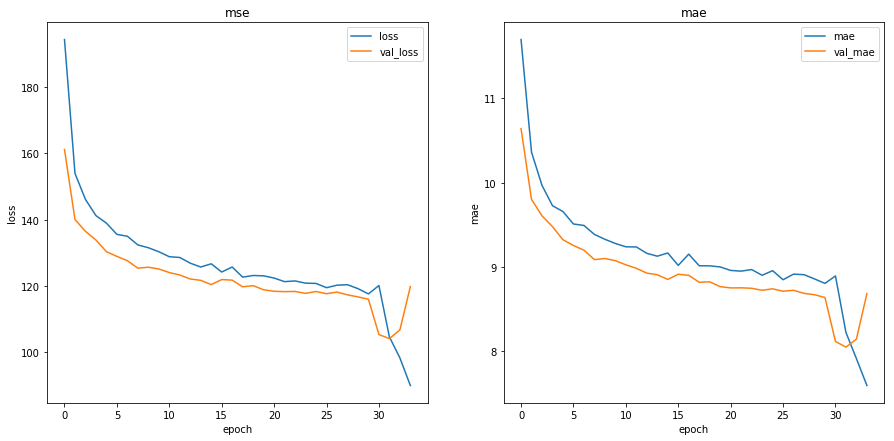

In [31]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2 ,1)
plt.title('mse')
plt.plot(all_loss, label='loss')
plt.plot(all_val_loss, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('mae')
plt.plot(all_mae, label='mae')
plt.plot(all_val_mae, label='val_mae')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend()

plt.show()